In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import typing
from typing import Type

import numpy as np
import torch

from devinterp.optim import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
import devinterp.utils as utils

import re
import yaml
from dataclasses import dataclass


from dgp import get_dataloader
from model import GPT

import torch.nn.functional as F
from utils import move_to_device

import pickle
import os

from utils.loading import Conf
from utils.llc import calculate_llc_for_file, evaluate_fn

from functools import partial

In [9]:
hf_repo_name = "3i23qszs"
model_dir = f'results/scratch/{hf_repo_name}'

In [10]:
config = Conf.load_from_yaml("config/conf.yaml")
config.device = "cuda" if torch.cuda.is_available() else "cpu"

dataloader = get_dataloader(
    n_relative_properties=config.data.n_relative_properties,
    n_descriptive_properties=config.data.n_descriptive_properties,
    n_descriptive_values=config.data.n_descriptive_values,
    num_of_classes_to_divide_over=config.data.num_of_classes_to_divide_over,
    prior_param=config.data.prior_param,
    props_prior_type=config.data.props_prior_type,
    n_entities=config.data.n_entities,
    instr_ratio=config.data.instr_ratio,
    max_sample_length=config.data.max_sample_length,
    num_iters=config.data.num_iters * config.data.batch_size,
    batch_size=config.data.batch_size,
    num_workers=config.data.num_workers,
    seed=config.seed,
)

pad_token_id = dataloader.dataset.pad_token_id

evaluator = partial(evaluate_fn, pad_token_id=pad_token_id, config=config)

In [11]:
num_chains = 5
num_draws = 150
iteration = 20_000
gammas = [100.0, 200.0, 400.0]
eps = [5e-4, 1e-3, 5e-3]
llcs = {}
# grid sweep
for e in eps:
    for g in gammas:
        print(f"e: {e}, g: {g}")
        llc = calculate_llc_for_file(
            iteration=iteration,
            dataloader=dataloader,
            model_dir=model_dir,
            config=config,
            evaluate_fn=evaluator,
            optimizer_kwargs=dict(lr=e, localization=g, nbeta=30),
            num_chains=num_chains,
            num_draws=num_draws,
        )
        llcs[(e, g)] = llc

e: 0.0005, g: 100.0


/workspace/ConceptPercolation/utils/loading.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f"{dirname}/{fname}", map_location=device)
/workspace/Conc

/workspace/ConceptPercolation/.venv/lib/python3.10/site-packages/devinterp/backends/default/slt/sampler.py:234: UserWarning: If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.
  warnings.warn(
Chain 4: 100%|██████████| 150/150 [00:24<00:00,  6.17it/s]


e: 0.0005, g: 200.0


Chain 4: 100%|██████████| 150/150 [00:24<00:00,  6.23it/s]


e: 0.0005, g: 400.0


Chain 4: 100%|██████████| 150/150 [00:23<00:00,  6.38it/s]


e: 0.001, g: 100.0


Chain 4: 100%|██████████| 150/150 [00:23<00:00,  6.32it/s]


e: 0.001, g: 200.0


Chain 4: 100%|██████████| 150/150 [00:24<00:00,  6.05it/s]


e: 0.001, g: 400.0


Chain 4: 100%|██████████| 150/150 [00:25<00:00,  5.92it/s]


e: 0.005, g: 100.0


Chain 4: 100%|██████████| 150/150 [00:25<00:00,  5.99it/s]


e: 0.005, g: 200.0


Chain 4: 100%|██████████| 150/150 [00:25<00:00,  5.86it/s]


e: 0.005, g: 400.0


Chain 4: 100%|██████████| 150/150 [00:25<00:00,  5.81it/s]


In [15]:
import pickle
dump_dir = f"./results/scratch/{hf_repo_name}/llc/"
grid_str = f"{len(eps)}_by_{len(gammas)}"
with open(f"{dump_dir}/icl1_sweep_it_{iteration}_draws_{num_draws}_{grid_str}.pkl", "wb") as f:
    pickle.dump(llcs, f)

In [87]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Literal

def plot_trace(llcs, eps, gammas, version: Literal['normal', 'mean_std', 'min_max'] = 'normal', figsize=(20, 20)):
    _, ax = plt.subplots(len(eps), len(gammas), figsize=figsize)
    std, mean, mins, maxs = {}, {}, {}, {}
    
    for i, e in enumerate(eps):
        for j, g in enumerate(gammas):
            llc_output = llcs[(e, g)]
            traces = llc_output["loss/trace"]
            all_mean = np.mean(traces)
            ax[i, j].hlines(all_mean, 0, len(traces[0]),
                            color="red", linestyle="--", linewidth=2)
            if version == 'normal':
                cmap = plt.get_cmap("viridis")
                for color, chain in enumerate(traces):
                    ax[i, j].plot(chain, alpha=0.7, color=cmap(color / len(traces)))
            
            elif version == 'mean_std':
                # Calculate mean and standard deviation
                trace_mean = np.mean(traces, axis=0)
                trace_std = np.std(traces, axis=0)
                ax[i, j].plot(trace_mean, color="blue")
                ax[i, j].fill_between(
                    np.arange(len(trace_mean)),
                    trace_mean - trace_std,
                    trace_mean + trace_std,
                    color="blue",
                    alpha=0.3,
                )
                
            elif version == 'min_max':
                # Calculate min and max for traces
                trace_mean = np.mean(traces, axis=0)
                trace_min = np.min(traces, axis=0)
                trace_max = np.max(traces, axis=0)
                ax[i, j].plot(trace_mean, color="blue")
                ax[i, j].fill_between(
                    np.arange(len(trace_mean)),
                    trace_min,
                    trace_max,
                    color="blue",
                    alpha=0.3,
                )
                
            ax[i, j].set_title(f"e: {e}, g: {g}")

    # Set font size for all subplots
    for a in ax.flatten():
        a.tick_params(axis="both", which="major", labelsize=16)
        a.set_title(a.get_title(), fontsize=16)
    
    plt.tight_layout()
    plt.show()


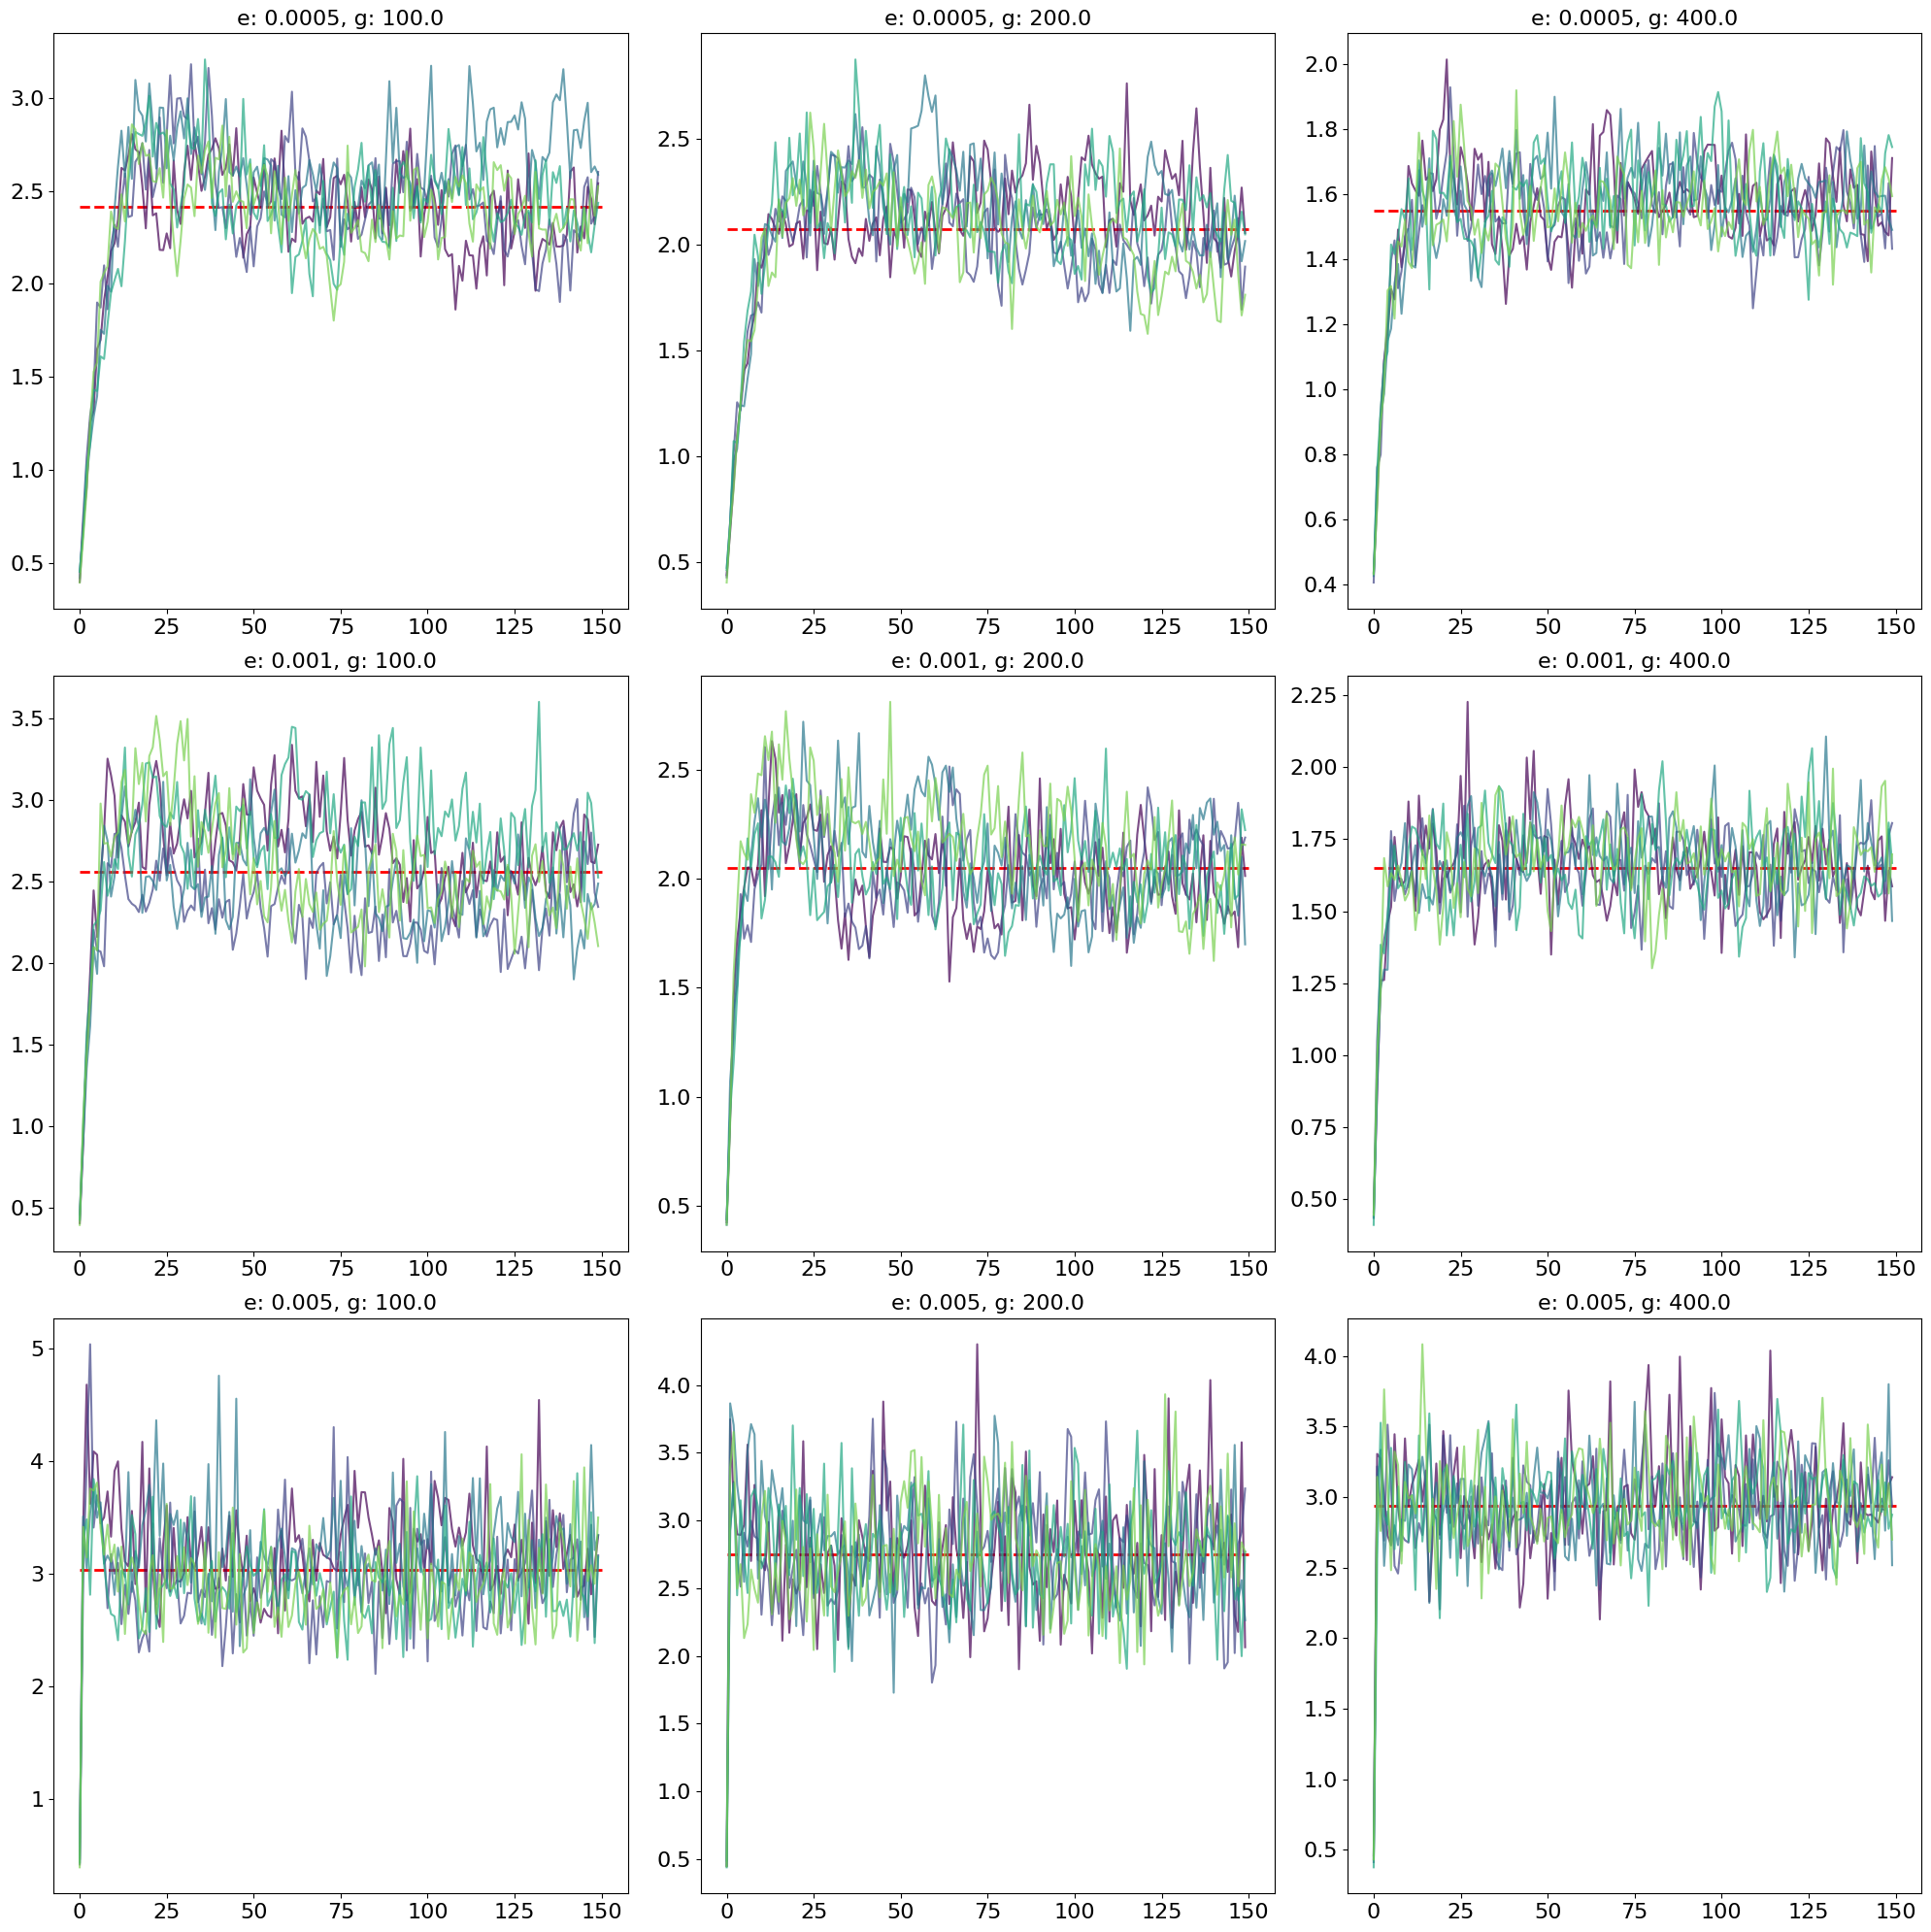

In [88]:
plot_trace(llcs, eps, gammas)

In [80]:
# plot chain average variance v/s mean 

def plot_variance_vs_mean(llcs, eps, gammas, figsize=(10, 10)):
    _, ax = plt.subplots(len(eps), len(gammas), figsize=figsize)
    for i, e in enumerate(eps):
        for j, g in enumerate(gammas):
            llc_output = llcs[(e, g)]
            traces = llc_output["loss/trace"]
            all_mean = np.mean(traces, axis=0)
            all_std = np.std(traces, axis=0)
            # ax[i, j].scatter(all_mean, all_std, color="blue", alpha=0.5, marker=".")

            # plot 1/snr curve
            snr = all_std / all_mean
            ax[i, j].scatter(all_mean, snr, color="red", alpha=0.5, marker=".")
            ax[i, j].set_title(f"e: {e}, g: {g}")
            ax[i, j].set_xlabel("Mean")
            
            # ax[i, j].legend(["Variance", "Variance/Mean"])

    plt.tight_layout()
    plt.show()

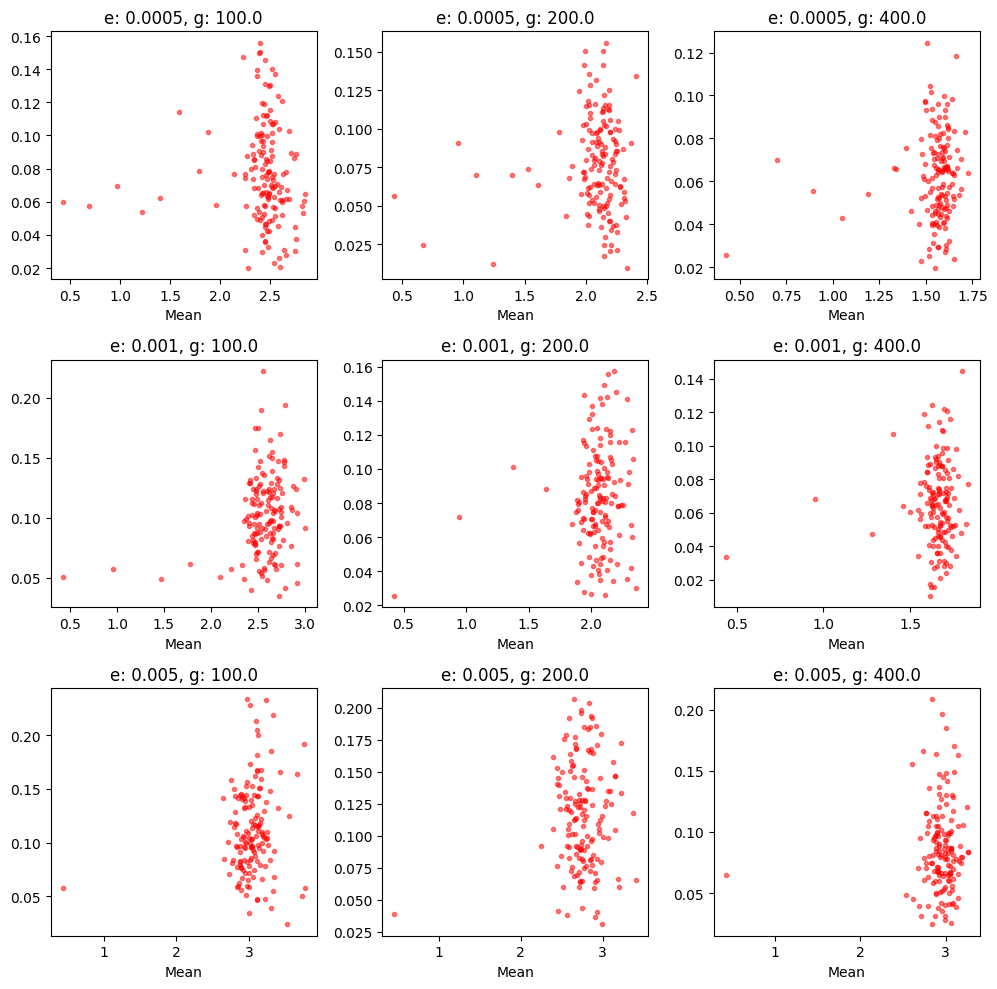

In [81]:
plot_variance_vs_mean(llcs, eps, gammas)

In [82]:
# plot chain average variance v/s mean as SNR for each (e, g) pair as a heatmap

def plot_normalised_stds(llcs, eps, gammas, llc = True):
    image_grid = np.zeros((len(eps), len(gammas)))
    for i, e in enumerate(eps):
        for j, g in enumerate(gammas):
            llc_output = llcs[(e, g)]
            traces = llc_output["loss/trace"]
            if llc:
                trace_mean = llc_output["llc/means"].mean() 
                trace_std = llc_output["llc/stds"].mean()
                nvar = trace_std / trace_mean
            else:
                trace_mean = np.mean(traces, axis=0)
                trace_std = np.std(traces, axis=0)
                nvar = (trace_std / (trace_mean + 1e-6)).mean()
            image_grid[i, j] = nvar
    plt.imshow(image_grid, cmap="viridis")
    plt.colorbar()
    plt.xticks(np.arange(len(gammas)), gammas)
    plt.yticks(np.arange(len(eps)), eps)
    plt.xlabel("Gamma")
    plt.ylabel("Epsilon")
    return image_grid

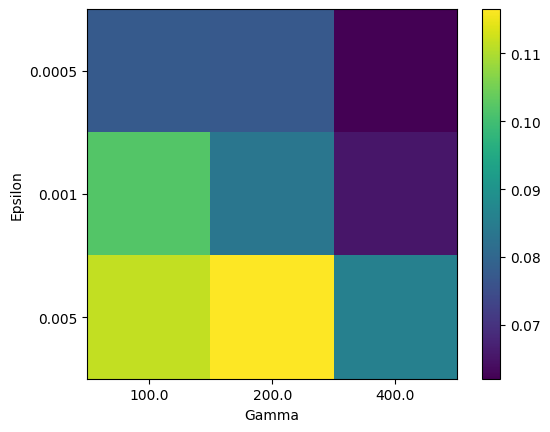

In [85]:
g1 = plot_normalised_stds(llcs, eps, gammas, False)

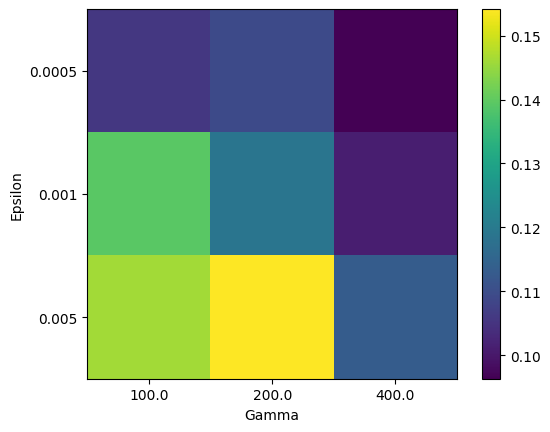

In [86]:
g2 = plot_normalised_stds(llcs, eps, gammas, True)

(array([[15.40446949, 16.46950722, 18.25614738],
        [11.06992054, 13.9885397 , 18.66320229],
        [10.46626282, 10.01978588, 13.90569687]]),
 array([[ 9.45362473,  9.14067936, 10.3819828 ],
        [ 7.18139172,  8.42200851,  9.88256454],
        [ 6.83881283,  6.48742676,  8.83362865]]))